In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [6]:
# FETCH MARKET DATA
ticker = 'AAPL'
data = yf.download(ticker, period='1y', progress=False, multi_level_index=False)
spot_price = data.Close.iat[-1]
risk_free_rate = 0.04
dividend_yield = 0.06
vol_annual = np.std(np.log(data['Close']/data["Close"].shift(1)).dropna()) * np.sqrt(252)

print(spot_price, vol_annual)

202.3800048828125 0.31484612919554994


In [16]:
# Define option parameters
start_time = time.time()
expiry_days = 60
maturity = expiry_days / 365.0 # Convert to years
strikes = np.linspace(spot_price*0.8, spot_price*1.2, 61)
steps = 1000 # Number of steps in binomial tree

print(strikes)
end_time = time.time()
print(f"{(end_time - start_time)*1000} miliseconds")

[161.90400391 163.25320394 164.60240397 165.951604   167.30080404
 168.65000407 169.9992041  171.34840413 172.69760417 174.0468042
 175.39600423 176.74520426 178.0944043  179.44360433 180.79280436
 182.14200439 183.49120443 184.84040446 186.18960449 187.53880452
 188.88800456 190.23720459 191.58640462 192.93560465 194.28480469
 195.63400472 196.98320475 198.33240479 199.68160482 201.03080485
 202.38000488 203.72920492 205.07840495 206.42760498 207.77680501
 209.12600505 210.47520508 211.82440511 213.17360514 214.52280518
 215.87200521 217.22120524 218.57040527 219.91960531 221.26880534
 222.61800537 223.9672054  225.31640544 226.66560547 228.0148055
 229.36400553 230.71320557 232.0624056  233.41160563 234.76080566
 236.1100057  237.45920573 238.80840576 240.15760579 241.50680583
 242.85600586]
0.9851455688476562 miliseconds


In [17]:
def binomial_american_call(S0, K, T, r, q, sigma, N):
    dt = T / N      # Time Setup
    u = np.exp(sigma * np.sqrt(dt)) # Up Factor
    d = 1 / u       # Down Factor
    p = (np.exp((r - q) * dt) - d) / (u - d)    # Risk-neutral probability

    # Initialize stock price tree
    stock = np.zeros((N + 1, N + 1))
    for i in range (N + 1):
        for j in range (i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initialize option value tree
    option = np.zeros((N + 1, N + 1))
    option[:, N] = np.maximum(0, stock[:, N] - K) # Payoff at maturity

    # Backwards induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            exercise = np.maximum(0, stock[j, i] - K) # Early exercise value
            hold = np.exp(-r * dt) * (p * option[j, i + 1] + (1 - p) * option [j + 1, i + 1])
            option[j,i] = np.maximum(exercise, hold) # Max of exercise or hold

    return option[0, 0]

In [18]:
option_prices = [binomial_american_call(spot_price, K, maturity, risk_free_rate, dividend_yield, vol_annual, steps) for K in strikes]

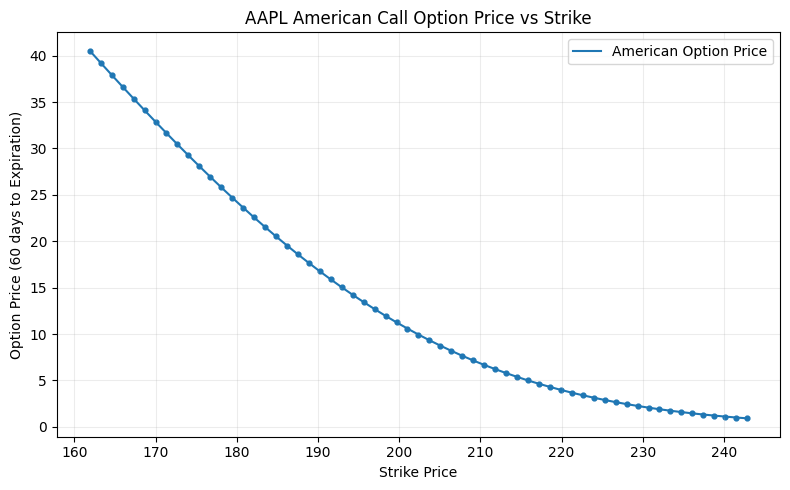

In [ ]:
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
plt.plot(strikes, option_prices, label="American Option Price")
plt.scatter(strikes, option_prices, s = 12)
plt.title(f"{ticker} American Call Option Price vs Strike")
plt.xlabel("Strike Price")
plt.ylabel("Option Price (60 days to Expiration)")
plt.grid(True, alpha = 0.24)
plt.legend()
plt.tight_layout()
plt.show()